In [1]:
text = sc.wholeTextFiles('Geolife Trajectories 1.3/Data/*/*')

In [2]:
data = text.flatMap(lambda x:x[1].split('\r\n')[6:])\
                   .map(lambda x:x.split(','))\
                   .filter(lambda x:len(x) == 7)

data.take(2)

[['39.984702',
  '116.318417',
  '0',
  '492',
  '39744.1201851852',
  '2008-10-23',
  '02:53:04'],
 ['39.984683',
  '116.31845',
  '0',
  '492',
  '39744.1202546296',
  '2008-10-23',
  '02:53:10']]

In [3]:
header = ['Latitude', 'Longitude', 'Altitude in feet', 'Date', 'Time']

df = data.map(lambda x:[float(x[0]), float(x[1]), float(x[3]), x[5], x[6]]).toDF(header)

df.printSchema()
df.show()
print(df.count(), 'Data points')

root
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Altitude in feet: double (nullable = true)
 |-- Date: string (nullable = true)
 |-- Time: string (nullable = true)

+---------+----------+----------------+----------+--------+
| Latitude| Longitude|Altitude in feet|      Date|    Time|
+---------+----------+----------------+----------+--------+
|39.984702|116.318417|           492.0|2008-10-23|02:53:04|
|39.984683| 116.31845|           492.0|2008-10-23|02:53:10|
|39.984686|116.318417|           492.0|2008-10-23|02:53:15|
|39.984688|116.318385|           492.0|2008-10-23|02:53:20|
|39.984655|116.318263|           492.0|2008-10-23|02:53:25|
|39.984611|116.318026|           493.0|2008-10-23|02:53:30|
|39.984608|116.317761|           493.0|2008-10-23|02:53:35|
|39.984563|116.317517|           496.0|2008-10-23|02:53:40|
|39.984539|116.317294|           500.0|2008-10-23|02:53:45|
|39.984606|116.317065|           505.0|2008-10-23|02:53:50|
|39.984568|11

In [4]:
position_subset = df.select('Latitude', 'Longitude').rdd.map(lambda x:list(x)).takeSample(True, 1000000)
position_subset_x = [ps[0] for ps in position_subset]
position_subset_y = [ps[1] for ps in position_subset]

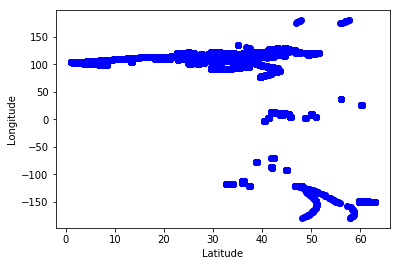

In [5]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.plot(position_subset_x, position_subset_y, 'ob')
plt.xlabel('Latitude') 
plt.ylabel('Longitude')
plt.show()